C:\Users\flare\AppData\Local\Temp\ipykernel_18236\1567751399.py:126: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(x, y)


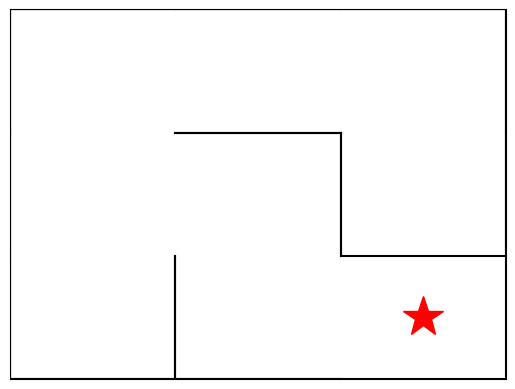

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# --- 迷路描画設定 ---
fig, ax = plt.subplots()
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=False, right=False, left=False, labelleft=False)

# ゴール表示（状態8は右下）
ax.plot([2.5], [0.5], marker="*", color='r', markersize=30)

# エージェント初期表示
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

# --- 壁を描画する関数 ---
def draw_maze_walls(theta):
    for s in range(len(theta)):
        x = s % 3
        y = 2 - (s // 3)
        for a, val in enumerate(theta[s]):
            if np.isnan(val):
                if a == 0:  # up
                    ax.plot([x, x+1], [y+1, y+1], color='black')
                elif a == 1:  # right
                    ax.plot([x+1, x+1], [y, y+1], color='black')
                elif a == 2:  # down
                    ax.plot([x, x+1], [y, y], color='black')
                elif a == 3:  # left
                    ax.plot([x, x], [y, y+1], color='black')

# 外枠の追加
ax.plot([0, 3], [0, 0], color='black')
ax.plot([0, 3], [3, 3], color='black')
ax.plot([0, 0], [0, 3], color='black')
ax.plot([3, 3], [0, 3], color='black')

# --- 遷移確率と方策定義 ---
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # 0
                    [np.nan, 1, np.nan, 1],  # 1
                    [np.nan, np.nan, 1, 1],  # 2
                    [1, 1, 1, np.nan],       # 3
                    [np.nan, np.nan, 1, 1],  # 4
                    [1, np.nan, np.nan, np.nan],  # 5
                    [1, np.nan, np.nan, np.nan],  # 6
                    [1, 1, np.nan, np.nan],  # 7
                    ])

draw_maze_walls(theta_0)  # 壁描画

def simple_convert_into_pi_from_theta(theta):
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    for i in range(m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
    return np.nan_to_num(pi)

pi_0 = simple_convert_into_pi_from_theta(theta_0)
[a, b] = theta_0.shape
Q = np.random.rand(a, b) * theta_0 * 0.1

# --- 行動選択・次状態・Q学習 ---
def get_action(s, Q, epsilon, pi_0):
    if np.random.rand() < epsilon:
        return np.random.choice([0, 1, 2, 3], p=pi_0[s])
    return np.nanargmax(Q[s])

def get_s_next(s, a, Q, epsilon, pi_0):
    if a == 0:
        return s - 3
    elif a == 1:
        return s + 1
    elif a == 2:
        return s + 3
    elif a == 3:
        return s - 1

def Q_learning(s, a, r, s_next, Q, eta, gamma):
    if s_next == 8:
        Q[s, a] += eta * (r - Q[s, a])
    else:
        Q[s, a] += eta * (r + gamma * np.nanmax(Q[s_next]) - Q[s, a])
    return Q

def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0
    a = get_action(s, Q, epsilon, pi)
    s_a_history = [[s, np.nan]]
    while True:
        s_a_history[-1][1] = a
        s_next = get_s_next(s, a, Q, epsilon, pi)
        s_a_history.append([s_next, np.nan])
        if s_next == 8:
            r = 1
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma)
        if s_next == 8:
            break
        s = s_next
        a = a_next
    return s_a_history, Q

# --- パラメータ設定 ---
eta = 0.1
gamma = 0.9
epsilon = 0.5

# --- 学習開始 ---
s_a_history, Q = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

# --- アニメーション描画関数 ---
def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    state = s_a_history[i][0]
    x = (state % 3) + 0.5
    y = 2.5 - (state // 3)
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(s_a_history), interval=400, repeat=False)
HTML(anim.to_jshtml())
